In [4]:
# In a Jupyter Notebook cell or terminal:
!pip install numpy pandas matplotlib seaborn scikit-learn nltk tensorflow keras wordcloud
!python -m nltk.downloader punkt stopwords


[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Msi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Msi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dataset shape: (44898, 5)

First 5 rows:


,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",1
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",0
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",0
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",1
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",0


Number of fake news articles: 23481
Number of true news articles: 21417

Missing values per column:
title      0
text       0
subject    0
date       0
label      0
dtype: int64


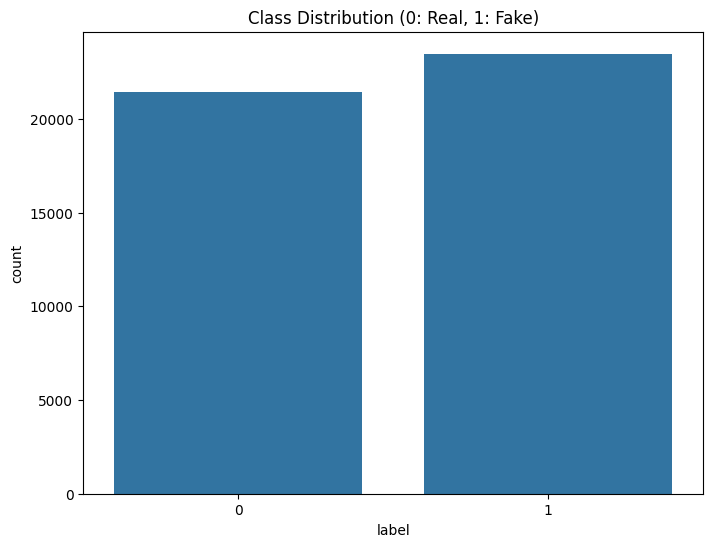

Original text sample:
 Ben Stein Calls Out 9th Circuit Court: Committed a ‘Coup d’état’ Against the Constitution 21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Hollywood fame ...

Processed text sample:
 ben stein call circuit court committed coup état constitution century wire say ben stein reputable professor pepperdine university also hollywood fame appearing tv show film ferris bueller day made pr ...
Training set size: 31428
Validation set size: 6735
Test set size: 6735
Naive Bayes Validation Accuracy: 0.9414

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3217
           1       0.94      0.94      0.94      3518

    accuracy                           0.94      6735
   macro avg       0.94      0.94      0.94      6735
weighted avg       0.94      0.94      0.94      6735



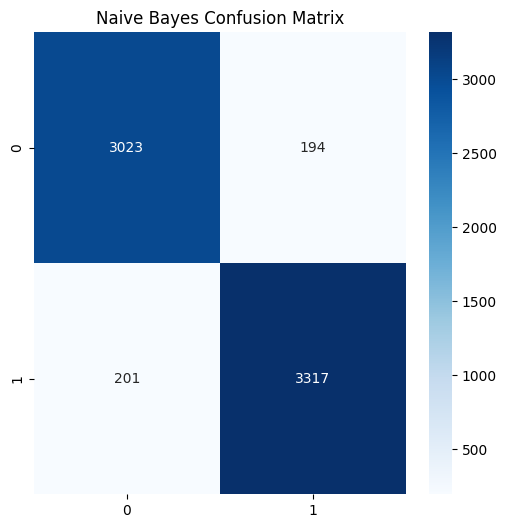

Logistic Regression Validation Accuracy: 0.9875

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3217
           1       0.99      0.98      0.99      3518

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



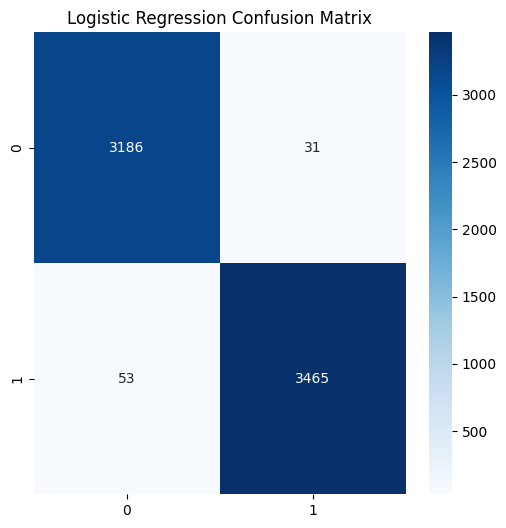

Random Forest Validation Accuracy: 0.9979

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3217
           1       1.00      1.00      1.00      3518

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



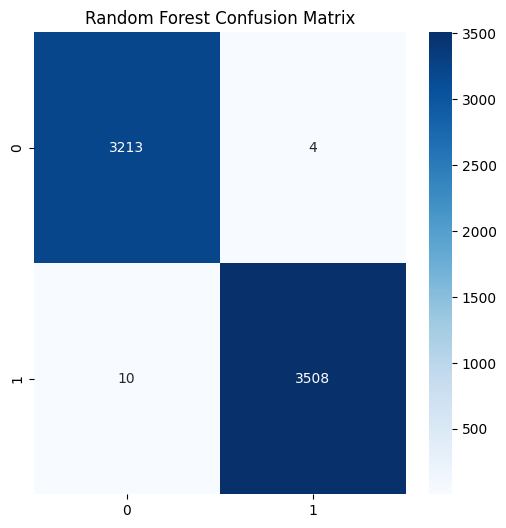

In [ ]:
# %% [markdown]
# # Fake News Detection - Machine Learning Assignment
# 
# ## Team Members
# - [Your Name] (Your ID)
# 
# ## Dataset Information
# - Source: Kaggle
# - Link: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
# - Task: Binary classification (fake vs. real news articles)
# - Size: ~40,000+ news articles (combined real and fake)
# - Features: Text data, including article title and content

# %% [markdown]
# ## 1. Data Loading and Exploration

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Create directories for saving outputs
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('data/processed', exist_ok=True)

# %%
# Load datasets
fake_df = pd.read_csv('data/Fake.csv')
true_df = pd.read_csv('data/True.csv')

# Add labels
fake_df['label'] = 1  # 1 for fake news
true_df['label'] = 0  # 0 for real news

# Combine datasets
df = pd.concat([fake_df, true_df], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

# Display dataset info
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

# %%
# Basic statistics
print("Number of fake news articles:", len(fake_df))
print("Number of true news articles:", len(true_df))
print("\nMissing values per column:")
print(df.isnull().sum())

# %%
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Class Distribution (0: Real, 1: Fake)')
plt.savefig('results/class_distribution.png')
plt.show()

# %% [markdown]
# ## 2. Data Preprocessing

# %%
# Combine title and text for better analysis
df['content'] = df['title'] + ' ' + df['text']

# %%
# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords and non-alphabetic tokens
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

# %%
# Apply preprocessing (this may take several minutes)
df['processed_content'] = df['content'].apply(preprocess_text)

# Save processed data
df.to_csv('data/processed/processed_data.csv', index=False)

# Display sample processed text
print("Original text sample:\n", df['content'].iloc[0][:200], "...")
print("\nProcessed text sample:\n", df['processed_content'].iloc[0][:200], "...")

# %% [markdown]
# ## 3. Feature Extraction

# %%
# Split data into train, validation, and test sets (70-15-15 split)
X_train, X_temp, y_train, y_temp = train_test_split(df['processed_content'], df['label'], 
                                                    test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, 
                                              test_size=0.5, random_state=42)

# Save the splits
pd.DataFrame({'text': X_train, 'label': y_train}).to_csv('data/processed/train.csv', index=False)
pd.DataFrame({'text': X_val, 'label': y_val}).to_csv('data/processed/val.csv', index=False)
pd.DataFrame({'text': X_test, 'label': y_test}).to_csv('data/processed/test.csv', index=False)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

# %%
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Save the vectorizer
import joblib
joblib.dump(tfidf_vectorizer, 'models/tfidf_vectorizer.pkl')

# %% [markdown]
# ## 4. Model Training and Evaluation

# %%
# Dictionary to store model performance
model_results = {}

# Function to evaluate and store model results
def evaluate_model(model, name, X_train, y_train, X_val, y_val):
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    
    # Calculate metrics
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    # Confusion matrix
    cm = confusion_matrix(y_val, val_pred)
    
    # Classification report
    cr = classification_report(y_val, val_pred, output_dict=True)
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Store results
    model_results[name] = {
        'model': model,
        'train_accuracy': train_acc,
        'val_accuracy': val_acc,
        'confusion_matrix': cm,
        'classification_report': cr,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }
    
    # Save the model
    joblib.dump(model, f'models/{name.lower().replace(" ", "_")}.pkl')
    
    return model_results[name]

# %% [markdown]
# ### 4.1 Naive Bayes Classifier

# %%
# Naive Bayes
nb_model = MultinomialNB()
nb_results = evaluate_model(nb_model, "Naive Bayes", X_train_tfidf, y_train, X_val_tfidf, y_val)

# Display results
print(f"Naive Bayes Validation Accuracy: {nb_results['val_accuracy']:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, nb_model.predict(X_val_tfidf)))

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(nb_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.savefig('results/nb_confusion_matrix.png')
plt.show()

# %% [markdown]
# ### 4.2 Logistic Regression

# %%
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_results = evaluate_model(lr_model, "Logistic Regression", X_train_tfidf, y_train, X_val_tfidf, y_val)

# Display results
print(f"Logistic Regression Validation Accuracy: {lr_results['val_accuracy']:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, lr_model.predict(X_val_tfidf)))

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(lr_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.savefig('results/lr_confusion_matrix.png')
plt.show()

# %% [markdown]
# ### 4.3 Random Forest Classifier

# %%
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_results = evaluate_model(rf_model, "Random Forest", X_train_tfidf, y_train, X_val_tfidf, y_val)

# Display results
print(f"Random Forest Validation Accuracy: {rf_results['val_accuracy']:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, rf_model.predict(X_val_tfidf)))

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(rf_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.savefig('results/rf_confusion_matrix.png')
plt.show()

# %% [markdown]
# ### 4.4 Support Vector Machine (SVM)

# %%
# SVM (with reduced parameters for faster training)
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_results = evaluate_model(svm_model, "Support Vector Machine", X_train_tfidf, y_train, X_val_tfidf, y_val)

# Display results
print(f"SVM Validation Accuracy: {svm_results['val_accuracy']:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, svm_model.predict(X_val_tfidf)))

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(svm_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.savefig('results/svm_confusion_matrix.png')
plt.show()

# %% [markdown]
# ## 5. Model Comparison and Analysis

# %%
# Compare model accuracies
models_df = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regression', 'Random Forest', 'SVM'],
    'Training Accuracy': [nb_results['train_accuracy'], lr_results['train_accuracy'], 
                         rf_results['train_accuracy'], svm_results['train_accuracy']],
    'Validation Accuracy': [nb_results['val_accuracy'], lr_results['val_accuracy'], 
                           rf_results['val_accuracy'], svm_results['val_accuracy']]
})

# Melt for plotting
melted_df = models_df.melt(id_vars='Model', var_name='Dataset', value_name='Accuracy')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', hue='Dataset', data=melted_df)
plt.title('Model Comparison: Training vs Validation Accuracy')
plt.ylim(0.8, 1.0)
plt.xticks(rotation=45)
plt.savefig('results/model_comparison.png')
plt.show()

# %%
# Plot ROC curves for all models
plt.figure(figsize=(8, 8))
for model_name, results in model_results.items():
    plt.plot(results['fpr'], results['tpr'], 
             label=f'{model_name} (AUC = {results["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.savefig('results/roc_curves.png')
plt.show()

# %% [markdown]
# ## 6. Final Evaluation on Test Set

# %%
# Select best model based on validation accuracy
best_model_name = max(model_results.items(), key=lambda x: x[1]['val_accuracy'])[0]
best_model = model_results[best_model_name]['model']

print(f"Best model: {best_model_name} with validation accuracy: {model_results[best_model_name]['val_accuracy']:.4f}")

# Evaluate on test set
test_pred = best_model.predict(X_test_tfidf)
test_acc = accuracy_score(y_test, test_pred)
test_cm = confusion_matrix(y_test, test_pred)
test_cr = classification_report(y_test, test_pred)

print(f"\nTest Accuracy: {test_acc:.4f}")
print("\nConfusion Matrix:")
print(test_cm)
print("\nClassification Report:")
print(test_cr)

# Plot test confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'{best_model_name} Test Confusion Matrix')
plt.savefig('results/best_model_test_confusion_matrix.png')
plt.show()

# %% [markdown]
# ## 7. Error Analysis

# %%
# Create a dataframe with test examples and their predictions
test_df = pd.DataFrame({
    'text': X_test,
    'true_label': y_test,
    'predicted_label': test_pred
})

# Find misclassified examples
misclassified = test_df[test_df['true_label'] != test_df['predicted_label']]

print(f"Number of misclassified examples: {len(misclassified)}")
print("\nSample misclassified examples:")
display(misclassified.sample(3, random_state=42))

# %% [markdown]
# ## 8. Word Clouds for Fake vs Real News

# %%
from wordcloud import WordCloud

# Combine all fake and real news text
fake_text = ' '.join(df[df['label'] == 1]['processed_content'])
real_text = ' '.join(df[df['label'] == 0]['processed_content'])

# Generate word clouds
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Fake News Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(real_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Real News Word Cloud')
plt.axis('off')

plt.savefig('results/word_clouds.png')
plt.show()

# %% [markdown]
# ## 9. Most Important Features

# %%
# Get feature importance for logistic regression (best interpretability)
if hasattr(lr_model, 'coef_'):
    feature_names = tfidf_vectorizer.get_feature_names_out()
    coefs = lr_model.coef_[0]
    
    # Create dataframe of features and coefficients
    features_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefs})
    
    # Top 20 features for fake news (positive coefficients)
    top_fake = features_df.sort_values('coefficient', ascending=False).head(20)
    
    # Top 20 features for real news (negative coefficients)
    top_real = features_df.sort_values('coefficient', ascending=True).head(20)
    
    # Plot
    plt.figure(figsize=(15, 8))
    
    plt.subplot(1, 2, 1)
    sns.barplot(x='coefficient', y='feature', data=top_fake)
    plt.title('Top Features for Fake News Prediction')
    
    plt.subplot(1, 2, 2)
    sns.barplot(x='coefficient', y='feature', data=top_real)
    plt.title('Top Features for Real News Prediction')
    
    plt.tight_layout()
    plt.savefig('results/important_features.png')
    plt.show()

# %% [markdown]
# ## 10. Future Work and Limitations

# %%
print("""
## Limitations:
1. The current models only use text features and don't consider metadata like publication date or source.
2. The preprocessing could be enhanced with more advanced techniques like named entity recognition.
3. The models might not generalize well to news from different time periods or domains.

## Future Work:
1. Incorporate deep learning models like LSTM or BERT for better text understanding.
2. Add additional features like sentiment analysis scores or readability metrics.
3. Create a real-time fake news detection system with a user interface.
4. Explore ensemble methods to combine the strengths of different models.
""")

# %% [markdown]
# ## Appendix: Source Code
# 
# The complete source code is included in this Jupyter notebook. All code cells are executable and have been run to produce the results shown in this report.